In [27]:
import numpy as np
import powerlaw
import random
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import stats
import os
import sys
import math



def getDistribution(keys, normalized = True):
    
    uniq_keys = np.unique(keys)
    bins = uniq_keys.searchsorted(keys)
    distr = np.bincount(bins) 

    if normalized == 1: distr = distr/float(np.sum(distr)) 
    
    return np.asarray(uniq_keys.tolist()), np.asarray(distr.tolist())


In [29]:
def get_art_curves( genre, title, field):

    colorr  = ''
    
    if 'music' in title.lower():
        genre1 = genre + '-80'
        colorr = 'darkred'
        limit  = '80'
    elif 'book' in title.lower():
        genre1 = genre + '-50'
        colorr = 'darkgreen'
        limit  = '50'
    elif 'movie' in title.lower() and 'art' not in title:
        genre1 = genre + '-10'
        colorr = 'steelblue'
        limit  = '10'
    elif 'art' in title.lower():
        genre1 = genre + '-20'
        colorr = 'steelblue'
        limit  = '20'
        

    x, y = zip(*[line.strip().split('\t') for line in open('DataToPlot/1_impact_distribution/1_impact_distribution_binned_'+genre1+'.dat')])
    x = [float(xx) for xx in x]
    y = [float(yy) for yy in y]
    
    
    files = os.listdir('Data/'+genre+'/'+field+'-'+genre+'-simple-careers-limit-'+limit)
    ijk   = 0
    nbins = 10
    yall  = []
        
    for fn in files:
        imdb, X, Y = zip(*[line.strip().split('\t') for line in open('Data/'+genre+'/'+field+'-'+genre+'-simple-careers-limit-'+limit+'/' + fn)])      
        Y = [float(yy) for yy in Y]
        yall += Y

    
    pxall, pyall = getDistribution(yall, True)
    fig, ax  = plt.subplots(1,1, figsize = (15,7))
    counts, bins, bars = ax.hist(yall, normed = True, bins = 10 ** np.linspace(np.log10(min(pxall)), np.log10(max(pxall)), nbins), log=True,alpha=0.0, cumulative=0)
    ax.plot((bins[1:] + bins[:-1])/2, counts, 's-', color = 'royalblue', alpha = 0.0, markersize = 0, linewidth = 5)
    bins = (bins[1:] + bins[:-1])/2    
    plt.close()    

        
    return (bins, counts)




def get_sci_curves(genre):


    x, y = zip(*[line.strip().split('\t') for line in open('DataToPlot/1_impact_distribution/1_impact_distribution_binned_'+genre+'.dat')])
    x = [float(xx) for xx in x]
    y = [float(yy) for yy in y]
  
    colorr = 'darkorange'
    
    files = os.listdir('../Data/Science/science-'+genre+'-simple-careers/')
    ijk   = 0
    nbins = 10
    yall  = []
       
    for fn in files:
        
        imdb, X, Y, cat = zip(*[line.strip().split('\t') for line in open('../Data/Science/science-'+genre+'-simple-careers/'+ fn) if 'c10' not in line] )
        Y = [float(yy) for yy in Y]
        yall += Y

    
    
    pxall, pyall = getDistribution(yall, True)

    minx= min(pxall)
    fig, ax  = plt.subplots(1,1, figsize = (15,7))
    
    if minx == 0: minx = 1
    counts, bins, bars = ax.hist(yall, normed = True, bins = 10 ** np.linspace(np.log10(minx), np.log10(max(pxall)), nbins), log=True,alpha=0.0, cumulative=0)
    ax.plot((bins[1:] + bins[:-1])/2, counts, 's-', color = 'royalblue', alpha = 0.0, markersize = 0, linewidth = 5)
    bins = (bins[1:] + bins[:-1])/2    
                    
    plt.close()
    
    return (bins, counts)
    

# Get the distribution curves

In [30]:
field_title = { #'director':      ('Movie directors', 'film'),
                    'art-director':  ('Movie art directors', 'film'),#,
                 #   'producer':      ('Movie producers' , 'film'),
                 #   'composer':      ('Soundtrack composers movie', 'film'),
                 #   'writer':        ('Plot writers movie', 'film'),
                    'hiphop':        ('Hip-hop music artists','music'),
                 #   'classical':     ('Classical musicians','music')
                }   

  
sci_fields = ['mathematics', 'psychology']


genre_curves = {}

for ind, genre in enumerate(sci_fields):  
    genre_curves[genre] = get_sci_curves(genre)   
    
 
for ind, (genre, title) in enumerate(field_title.items()):
    genre_curves[genre] = get_art_curves(genre, title[0], title[1])   


In [ ]:
fig, ax  = plt.subplots(1,1, figsize = (15,7))

from sklearn.metrics import auc

maxy = 0
miny = 100000000000
for g, (x,y) in genre_curves.items():
    if max(x) > maxy:
        maxy = max(x)
    if min(x) < miny:
        miny = min(x)

        
genre_curves_rescaled  = {}
minxmaxx = {}

for g, (x,y) in genre_curves.items():
    maxx  = max(x)
    minx  = min(x)
    x     = [(xx-minx)  *maxy/maxx for xx in x]
    meany = auc(x,y)
    y     = [yy/meany for yy in y]
    
    
    minxmaxx[g] = (minx, maxx)

     
    genre_curves_rescaled[g] = (x,y)
    
        
for g, (x,y) in genre_curves_rescaled.items():
    ax.plot(x,y, 'o-', label = g)
    

ax.legend(loc = 'best')
ax.set_xscale('log')
ax.set_yscale('log')

GlobalMax = maxy

print 'Impact rescale factors:'
print 'Global max: ', maxy
print 'Field_specific:'
for field, (minx, maxx) in minxmaxx.items():
    print field, minx, maxx

# Do stuff on career level, not w the actual distributions

In [31]:
def get_impact_values(folder):
    
    files = sorted(os.listdir(folder))[0:1000]
    #files = os.listdir(folder)   
    
    yall = []
    for fn in files:
        
        try:
            imdb, X, Y, cat = zip(*[line.strip().split('\t') for line in open(folder+ fn) if 'year' not in line] )
        except:
            imdb, X, Y = zip(*[line.strip().split('\t') for line in open(folder+ fn) if 'year' not in line] )

        Y = [float(yyy) for yyy in Y]
        yall += Y
        
    impactmin = min(yall)
    impactmax = max(yall)
    
    if impactmin == 0.0: impactmin = 1.0 
    
    return impactmin, impactmax



def get_data_distr(folder):
    
    files = sorted(os.listdir(folder))[0:1000]
    #files = os.listdir(folder)

    yall = []
    for fn in files:
        
        try:
            imdb, X, Y, cat = zip(*[line.strip().split('\t') for line in open(folder+ fn) if 'year' not in line] )
        except:
            imdb, X, Y = zip(*[line.strip().split('\t') for line in open(folder+ fn) if 'year' not in line] )
      
        Y = [float(yy) for yy in Y]
        yall += Y
    
    fig, ax  = plt.subplots(1,1, figsize = (15,7))
    nbins = 10
    minx = min(yall)
    if minx == 0: minx = 1
    pxall, pyall = getDistribution(yall, True)        
    counts, bins, bars = ax.hist(yall, normed = True, bins = 10 ** np.linspace(np.log10(minx), np.log10(max(pxall)), nbins), log=True,alpha=0.0, cumulative=0)
    ax.plot((bins[1:] + bins[:-1])/2, counts, 's-', color = 'royalblue', alpha = 0.0, markersize = 0, linewidth = 5)
    bins = (bins[1:] + bins[:-1])/2    
                    
    plt.close()
    
    return (bins, counts)



def get_impact(impacts):
    
    fig, ax  = plt.subplots(1,1, figsize = (15,7))
    nbins = 20
    minx = min(impacts)
    pxall, pyall = getDistribution(impacts, True)    
    if minx == 0: minx = 1
    counts, bins, bars = ax.hist(impacts, normed = True, bins = 10 ** np.linspace(np.log10(minx), np.log10(max(pxall)), nbins), log=True,alpha=0.0, cumulative=0)
    ax.plot((bins[1:] + bins[:-1])/2, counts, 's-', color = 'royalblue', alpha = 0.0, markersize = 0, linewidth = 5)
    bins = (bins[1:] + bins[:-1])/2    
                    
    plt.close()
    
    return (bins, counts)

mathematics 1000
psychology 1000
jazz 3842
director 7389


Text(0.5,1,'Rescaled')

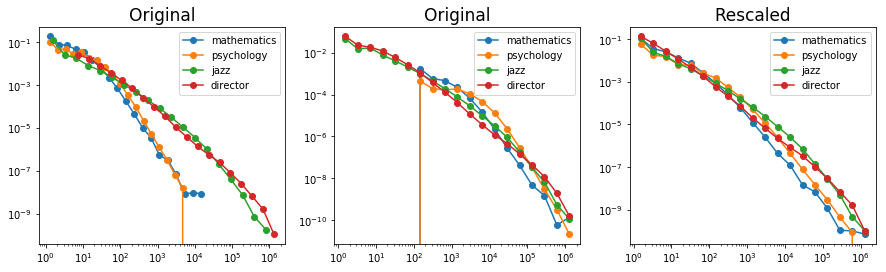

In [35]:
fields = [('mathematics', '../Data/Science/science-' + 'mathematics' + '-simple-careers/'),
          ('psychology', '../Data/Science/science-' + 'psychology' + '-simple-careers/'),
          ('jazz'       , 'Data/jazz/music-'+'jazz'+'-simple-careers-limit-80/')   ,
          ('director'       , 'Data/director/film-director-simple-careers-limit-10/') 
         ]

GLOBALMAX    = 0
GENRE_MINMAX = {}

for field, folder in fields:
    impactmin, impactmax = get_impact_values(folder)
    if impactmax > GLOBALMAX:
        GLOBALMAX = impactmax
    GENRE_MINMAX[field] = (impactmin, impactmax)


#print GLOBALMAX
#print GENRE_MINMAX



# https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range
def rescale(impact, GLOBALMAX, MINMAX):   
    miny, maxy = MINMAX
    impact = math.log(impact)
    miny   = math.log(miny)
    maxy   = math.log(maxy)
    maxG   = math.log(GLOBALMAX)

    newimpact = math.exp(  (impact - miny) / (maxy - miny) * (maxG)  )
    
    return newimpact


def linrescale(impact, GLOBALMAX, MINMAX):   
    miny, maxy = MINMAX
    impact = impact
    miny   = miny
    maxy   = maxy
    maxG   = GLOBALMAX

    newimpact = (impact - miny) / (maxy - miny) * (maxG)  
    
    return newimpact




f, ax = plt.subplots(1,3,figsize = (15,4))

for field, folder in fields:
    
    impacts_genre     = []
    impacts_genre_o   = []
    impacts_genre_lin = []
 
    folderout = folder.replace('../', '').replace('/Science/', '/').split('-limit')[0].replace('Data', 'Data_rescaled')
    
    folderout = folderout.replace(field + '/', '', 1)
    
    if not os.path.exists(folderout):
        os.makedirs(folderout)
    
    
    MINMAX = GENRE_MINMAX[field]
    miny, maxy  = MINMAX
    files = os.listdir(folder)
    
    print field, len(files)
    
    for fn in files[0:1000]:
        
    

        fileout = open(folderout + '/' + fn, 'w')
        
        for line in open(folder+fn):
            
            cat = ''
            
            if 'year' not in line:
                if 'science' in folder:
                    paper_id, year, c10, cat = line.strip().split('\t')
                    c10 = float(c10)
                else:
                    paper_id, year, c10 = line.strip().split('\t')
                    c10 = float(c10)

                if c10 == 0: c10 = 1 
                impacts_genre_o.append(c10)
                c11 = linrescale(c10, GLOBALMAX, MINMAX)    
                c10 = rescale(c10, GLOBALMAX, MINMAX)
                impacts_genre.append(c10)
                
                
                impacts_genre_lin.append(c11)

                
                
                if len(cat) > 0:          
                    fileout.write(paper_id + '\t' + year + '\t' + str(c10) + '\t' + cat + '\n')
                else:
                    fileout.write(paper_id + '\t' + year + '\t' + str(c10) + '\n')
    
                    

        fileout.close()        
                
        
    Xy, Yy = get_impact(impacts_genre)
    ax[2].plot(Xy,Yy, 'o-', label = field)
    
    Xy, Yy = get_impact(impacts_genre_o)
    ax[0].plot(Xy,Yy, 'o-', label = field)    
          
    Xy, Yy = get_impact(impacts_genre_lin)
    ax[1].plot(Xy,Yy, 'o-', label = field)    
    
ax[0].legend(loc = 'best')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Original', fontsize = 17)
 
    
ax[1].legend(loc = 'best')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Original', fontsize = 17)    
    
ax[2].legend(loc = 'best')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Rescaled', fontsize = 17)


#plt.savefig('20181113_4_demo_impact_distr_rescaled.png')

# Evol optimization...

# Compute the Q-p stuff...
    -luck skill plot
    - plot on R model
    - plot on Q model
